In [1]:
import numpy as np
import time, os, sys
from urllib.parse import urlparse
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi'] = 300
from cellpose import utils, io, models
from skimage import exposure, filters, segmentation, measure, color, morphology
import pandas as pd
import napari
from scipy import stats
import skimage
import seaborn as sns

/home/aydoganlab/miniconda3/envs/cellpose/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Define useful functions

In [2]:
def segment_channel(fname, mip_fname, z_slice, nuc_diam, channel, r_out, r_in, viz=False):
    '''This function will streamline the segmentation, labeling, and measurement code blocks
    that were used in a previous version of this notebook into one function.'''
    
    # Initialize indices that we can use as a handle for mean intensity data for the channel
    channels = ['mean_intensity_Sqh-mCh', 'mean_intensity_YFP', 
                'mean_intensity_CFP', 'mean_intensity_FRET']
    
    # Segment nuclei and generate labels/rois
    image, mask = segment_image(fname, mip_fname, z_slice, nuc_diam, channel)
    # Measure from rois
    im_slice, rois = label_regions_at_z(image, mask, z_slice)
    
    # Generate donut around nucleus ROI as background for background subtraction
    label = morphology.label(mask)
    expanded = segmentation.expand_labels(label, distance=r_out)
    expanded_1 = segmentation.expand_labels(label, distance=r_in)
    background_mask = expanded ^ expanded_1
    
    im_slice, bg_rois = label_regions_at_z(image, background_mask, z_slice, bg_sub=True)
    rois[channels[channel] + '_corr'] = rois[channels[channel]] - bg_rois[channels[channel]]
    rois[channels[channel] + '_bg'] = bg_rois[channels[channel]]
    
    # Visualize
    if viz:
        visualize_rois(im_slice, rois, mask)
        visualize_rois(im_slice, bg_rois, background_mask)
    
    return rois, mask, im_slice

In [3]:
def get_measurements_4(delayed_nuc_labels, regular_nuc_labels, measurements):
    '''This function will pull out FRET measurements from two paired sets of nuclei.
    It will return a dataframe which has measurements annotated based on whether it came
    from delayed or regular nuclei.'''
    
    tags = list()
    
    # 'Raw' measurements of FRET on nuclear ROIs
    measurements['FRET/CFP'] = measurements['mean_intensity_FRET']/measurements['mean_intensity_CFP']
    measurements['YFP/CFP'] = measurements['mean_intensity_YFP']/measurements['mean_intensity_CFP']
    measurements['FRET/YFP'] = measurements['mean_intensity_FRET']/measurements['mean_intensity_YFP']
    
    # Background-subtracted measurements of FRET
    measurements['FRET/CFP bg_sub'] = measurements['mean_intensity_FRET_corr_seg']/measurements['mean_intensity_CFP_corr_seg']
    measurements['YFP/CFP bg_sub'] = measurements['mean_intensity_YFP_corr']/measurements['mean_intensity_CFP_corr_seg']
    measurements['FRET/YFP bg_sub'] = measurements['mean_intensity_FRET_corr_seg']/measurements['mean_intensity_YFP_corr']
    
    # FRET on cytoplasmic region
    measurements['FRET/CFP cyto'] = measurements['mean_intensity_FRET_bg']/measurements['mean_intensity_CFP_bg']
    measurements['YFP/CFP cyto'] = measurements['mean_intensity_YFP_bg']/measurements['mean_intensity_CFP_bg']
    measurements['FRET/YFP cyto'] = measurements['mean_intensity_FRET_bg']/measurements['mean_intensity_YFP_bg']
    
    for i in range(len(measurements)):
        if measurements.iloc[i]['label'] in delayed_nuc_labels:
            tags.append('delayed')
        elif measurements.iloc[i]['label'] in regular_nuc_labels:
            tags.append('normal')
        else:
            tags.append('other')
    
    measurements['tag'] = tags
    
    return measurements

In [4]:
def get_fret_measurements(delayed_nuc_labels, regular_nuc_labels, measurements, mode='andrew'):
    '''This function will pull out FRET measurements from two paired sets of nuclei.
    It will return two lists of the normalized fret values.'''
    fret_norm_delayed = list()
    fret_norm_regular = list()
    
    if len(delayed_nuc_labels) == len(regular_nuc_labels): # Ensure that you're comparing pairs of nuclei
        for i in range(len(delayed_nuc_labels)):
            fret_int_delayed = measurements.loc[delayed_nuc_labels[i] - 1].at['mean_intensity_FRET']
            if mode == 'andrew':
                yfp_int_delayed = measurements.loc[delayed_nuc_labels[i] - 1].at['mean_intensity_YFP']       
                fret_norm_delayed.append(fret_int_delayed/yfp_int_delayed)
            elif mode == 'stefano':
                cfp_int_delayed = measurements.loc[delayed_nuc_labels[i] - 1].at['mean_intensity_CFP']
                fret_norm_delayed.append(fret_int_delayed/cfp_int_delayed)        

            fret_int_regular = measurements.loc[regular_nuc_labels[i] - 1].at['mean_intensity_FRET']
            if mode =='andrew':
                yfp_int_regular = measurements.loc[regular_nuc_labels[i] - 1].at['mean_intensity_CFP']
                fret_norm_regular.append(fret_int_regular/yfp_int_regular)
            elif mode == 'stefano':
                cfp_int_regular = measurements.loc[regular_nuc_labels[i] - 1].at['mean_intensity_CFP']
                fret_norm_regular.append(fret_int_regular/cfp_int_regular)
        return fret_norm_delayed, fret_norm_regular
    else:
        print('Lengths of label index arrays must be the same')

In [5]:
def load_coords(csv_fname):
    '''This function will take in a csv filename as an input and then output a list
    which contains the x-y coordinates of the nuclei of interest.'''
    
    coords = pd.read_csv(csv_fname)
    
    coord_list = list()
    
    for i in range(0, len(coords)):
        x = coords.at[i, 'X']
        y = coords.at[i, 'Y']
        coord_list.append([x, y])
    return coord_list

In [6]:
def match_coords(coords, df, max_distance=20):
    '''This function will take in coordinate data and match the label which is closest to
    that coordinate.'''
    labels = list()
    for i in range(0, len(coords)):
        x_1 = coords[i][0]
        y_1 = coords[i][1]
        point_1 = np.array([x_1, y_1])
        min_distance = max_distance # Define threshold
        for j in range(0, len(df)):
            y_2 = df.at[j, 'centroid-0']
            x_2 = df.at[j, 'centroid-1']
            point_2 = np.array([x_2, y_2])
            #print(point_2)
            dist = np.linalg.norm(point_1 - point_2) # Calculate distance
            if dist < min_distance:
                min_distance = dist
                label_idx = j
            else:
                print(dist)
        print(i, j)
        labels.append(df.at[label_idx, 'label'])
    return labels

In [7]:
def match_labels(df_1, df_2, mean_channel_intensity, max_distance=20 ):
    '''This function will match the measurements from two different segmentations and merge
    results into one dataframe. Each segmentation will result in some mean intensity measurement
    and this function will map those measurements into one.'''
    mean_ints = list()
    bg_ints = list()
    for i in range(0, len(df_1)):
        mean_int = np.nan
        x_1 = df_1.at[i, 'centroid-0']
        y_1 = df_1.at[i, 'centroid-1']
        point_1 = np.array([x_1, y_1])
        label_idx = None # Reset label_idx 
        min_distance = max_distance # Define threshold
        
        for j in range(0, len(df_2)):
            x_2 = df_2.at[j, 'centroid-0'] # Get centroid coordinates
            y_2 = df_2.at[j, 'centroid-1']
            point_2 = np.array([x_2, y_2]) 
            
            dist = np.linalg.norm(point_1 - point_2) # Calculate distance
            if dist < min_distance:
                min_distance = dist
                label_idx = j
        
        if label_idx == None:
            mean_ints.append(np.nan)
            continue        
        elif isinstance(label_idx, int): # Only appends if there was a match        
            mean_ints.append(df_2.at[label_idx, mean_channel_intensity + '_corr'])
            bg_ints.append(df_2.at[label_idx, mean_channel_intensity + '_bg'])
        
    
    df_1[mean_channel_intensity + '_corr_seg'] = mean_ints
    df_1[mean_channel_intensity + '_bg'] = mean_ints
    if len(mean_ints) == len(df_1): # Ensures that things were matched properly
        return df_1
    else:
        print('error')
        return
            

In [8]:
def get_fret_measurements_3(delayed_nuc_labels, regular_nuc_labels, measurements, mode=1):
    '''This function will pull out FRET measurements from two paired sets of nuclei.
    It will return two lists of the normalized fret values.'''
    fret_norm_delayed = list()
    fret_norm_regular = list()
    
    if len(delayed_nuc_labels) == len(regular_nuc_labels): # Ensure that you're comparing pairs of nuclei
        for delayed_nuc_label, regular_nuc_label in zip(delayed_nuc_labels, regular_nuc_labels):
            cfp_int_delayed = measurements.loc[delayed_nuc_label - 1].at['mean_intensity_CFP_corr_seg']
            if mode == 1:
                fret_int_delayed = measurements.loc[delayed_nuc_label - 1].at['mean_intensity_FRET_corr_seg']
                fret_norm_delayed.append(fret_int_delayed/cfp_int_delayed)
            elif mode == 2:
                yfp_int_delayed = measurements.loc[delayed_nuc_label - 1].at['mean_intensity_YFP_corr']       
                fret_norm_delayed.append(yfp_int_delayed/cfp_int_delayed)        
                            
            cfp_int_regular = measurements.loc[regular_nuc_label - 1].at['mean_intensity_CFP_corr_seg']
            if mode == 1:
                fret_int_regular = measurements.loc[regular_nuc_label - 1].at['mean_intensity_FRET_corr_seg']
                fret_norm_regular.append(fret_int_regular/cfp_int_regular)
            elif mode == 2:
                yfp_int_regular = measurements.loc[regular_nuc_label - 1].at['mean_intensity_YFP_corr']
                fret_norm_regular.append(yfp_int_regular/cfp_int_regular)
        return fret_norm_delayed, fret_norm_regular
    else:
        print('Lengths of label index arrays must be the same')

In [9]:
def get_fret_measurements_2(delayed_nuc_labels, regular_nuc_labels, measurements, mode='andrew'):
    '''This function will pull out FRET measurements from two paired sets of nuclei.
    It will return two lists of the normalized fret values.'''
    fret_norm_delayed = list()
    fret_norm_regular = list()
    
    if len(delayed_nuc_labels) == len(regular_nuc_labels): # Ensure that you're comparing pairs of nuclei
        for delayed_nuc_label, regular_nuc_label in zip(delayed_nuc_labels, regular_nuc_labels):
            fret_int_delayed = measurements.loc[delayed_nuc_label - 1].at['mean_intensity_FRET_corr_seg']
            if mode == 'andrew':
                yfp_int_delayed = measurements.loc[delayed_nuc_label - 1].at['mean_intensity_YFP_corr']       
                fret_norm_delayed.append(fret_int_delayed/yfp_int_delayed)
            elif mode == 'stefano':
                cfp_int_delayed = measurements.loc[delayed_nuc_label - 1].at['mean_intensity_CFP_corr_seg']
                fret_norm_delayed.append(fret_int_delayed/cfp_int_delayed)        

            fret_int_regular = measurements.loc[regular_nuc_label - 1].at['mean_intensity_FRET_corr_seg']
            if mode =='andrew':
                yfp_int_regular = measurements.loc[regular_nuc_label - 1].at['mean_intensity_CFP_corr_seg']
                fret_norm_regular.append(fret_int_regular/yfp_int_regular)
            elif mode == 'stefano':
                cfp_int_regular = measurements.loc[regular_nuc_label - 1].at['mean_intensity_CFP_corr_seg']
                fret_norm_regular.append(fret_int_regular/cfp_int_regular)
        return fret_norm_delayed, fret_norm_regular
    else:
        print('Lengths of label index arrays must be the same')

In [10]:
def get_fret_measurements(delayed_nuc_labels, regular_nuc_labels, measurements, mode='andrew'):
    '''This function will pull out FRET measurements from two paired sets of nuclei.
    It will return two lists of the normalized fret values.'''
    fret_norm_delayed = list()
    fret_norm_regular = list()
    
    if len(delayed_nuc_labels) == len(regular_nuc_labels): # Ensure that you're comparing pairs of nuclei
        for delayed_nuc_label, regular_nuc_label in zip(delayed_nuc_labels, regular_nuc_labels):
            fret_int_delayed = measurements.loc[delayed_nuc_label - 1].at['mean_intensity_FRET']
            if mode == 'andrew':
                yfp_int_delayed = measurements.loc[delayed_nuc_label - 1].at['mean_intensity_YFP']       
                fret_norm_delayed.append(fret_int_delayed/yfp_int_delayed)
            elif mode == 'stefano':
                cfp_int_delayed = measurements.loc[delayed_nuc_label - 1].at['mean_intensity_CFP']
                fret_norm_delayed.append(fret_int_delayed/cfp_int_delayed)        

            fret_int_regular = measurements.loc[regular_nuc_label - 1].at['mean_intensity_FRET']
            if mode =='andrew':
                yfp_int_regular = measurements.loc[regular_nuc_label - 1].at['mean_intensity_CFP']
                fret_norm_regular.append(fret_int_regular/yfp_int_regular)
            elif mode == 'stefano':
                cfp_int_regular = measurements.loc[regular_nuc_label - 1].at['mean_intensity_CFP']
                fret_norm_regular.append(fret_int_regular/cfp_int_regular)
        return fret_norm_delayed, fret_norm_regular
    else:
        print('Lengths of label index arrays must be the same')

In [11]:
def get_sqh_measurements(delayed_nuc_labels, regular_nuc_labels, measurements):
    '''This function will pull out Sqh intensity measurements from two paired 
    sets of nuclei.'''
    sqh_delayed = list()
    sqh_regular = list()
    for delayed_nuc_label, regular_nuc_label in zip(delayed_nuc_labels, regular_nuc_labels):
        sqh_int_delayed = measurements.loc[delayed_nuc_label - 1].at['mean_intensity_Sqh-mCh']
        sqh_delayed.append(sqh_int_delayed)

        sqh_int_regular = measurements.loc[regular_nuc_label - 1].at['mean_intensity_Sqh-mCh']
        sqh_regular.append(sqh_int_regular)
    return sqh_delayed, sqh_regular

In [12]:
def plot_paired_fret(normal_fret_vals, delayed_fret_vals, fig_title, save=False, output_dir=None, ylabel='$I_{FRET}/I_{CFP}$ (A.U.)', title=True):
    '''This function will take in the fret values and plot them as a paired
    scatter plot.'''
    # plotting the points
    plt.scatter(np.zeros(len(normal_fret_vals)), normal_fret_vals, color = 'black')
    plt.scatter(np.ones(len(delayed_fret_vals)), delayed_fret_vals, color = 'red')

    # plotting the lines
    for i in range(len(normal_fret_vals)):
        plt.plot( [0,1], [normal_fret_vals[i], delayed_fret_vals[i]],linestyle='--', c='black')

    plt.xticks([0,1], ['Regular', 'Delayed'])
    plt.ylabel(ylabel)
    if title:
        plt.title(fig_title)

    if save:
        plt.savefig(output_dir)
    plt.show()

In [13]:
def paired_ttest(var_1, var_2, alternative='two-sided'):
    t, p = stats.ttest_rel(var_1, var_2, alternative=alternative)
    print('p = ' + str(p))
    if p < 0.05:
        print('The two populations are statistically different')

In [14]:
def segment_image(fname, fname_mip, z, d, channel):
    '''This function will read in an image and segment it at a specific
    optical section, z. This function uses the CellPose package which can
    segment nuclear and cytoplasmic regions. I am only using the nuclear 
    model in this implementation. This model relies on the parameter, d,
    which is the approximate diameter of nuclei, in pixels.
    
    This will output the intensity image and the mask.'''
    
    # Load images
    image = io.imread(fname)
    image_mip = io.imread(fname_mip)
    #p2, p98 = np.percentile(image[:,channel], (2, 98)) # Comment out because my pre-processing happens in fiji now
    #image_rescale = exposure.rescale_intensity(image[:,channel], in_range=(p2, p98))
    
    model = models.Cellpose(model_type='nuclei')
    channels = [0, 2]
    
    # Segmentation step
    mask, flow, style, diam = model.eval(image_mip, diameter=d, channels=channels)
    mask = segmentation.clear_border(mask, buffer_size=5)
    
    # Visualization step
    fig, ax = plt.subplots(1, 4)
    ax[0].imshow(image[z,channel])
    ax[0].set_title('Optical Slice')
    ax[1].imshow(image_mip)
    ax[1].set_title('Max. Int. Proj.')
    ax[2].imshow(mask)
    ax[2].set_title('Segmented')
    ax[3].imshow(image[z,channel])
    ax[3].imshow(mask, alpha=0.5)
    ax[3].set_title('Slice/Mask Overlay')
    fig.tight_layout()
    
    return image, mask

In [15]:
def local_bg_sub(image, df_measurement, label, z, channel, ch_idx, viz=False, r_out=10, r_in=2):
    '''This will background subtract each nucleus using an annulus around that nucleus.'''
    
    expanded = segmentation.expand_labels(label, distance=r_out)
    expanded_1 = segmentation.expand_labels(label, distance=r_in)
    
    image_slice, df_measurement_corr = label_regions_at_z(image, expanded ^ expanded_1, z)
    
    df_measurement_corr[channel + '_corr'] = measured_regions_t0[channel] - measured_regions_test[channel]
    
    # Visualization step
    if viz:
        fig, ax = plt.subplots(1, 4)
        ax[0].imshow(label)
        ax[0].set_title('label')
        ax[1].imshow(expanded)
        ax[1].set_title('expanded label')
        ax[2].imshow(expanded ^ expanded_1)
        ax[2].set_title('subtracted roi')
        ax[3].imshow(image_slice)
        ax[3].set_title('raw image')
    
    return df_measurement_corr

In [16]:
def label_regions_at_z(image, label, z, bg_sub=False):
    '''This function will take in the intensity and binary images and generate a pandas dataframe
    that will have the relevant properties for measuring FRET intensities.'''
    
    im_slice = image[z]
    im_slice = np.moveaxis(im_slice, 0, 2)
    
    if not bg_sub:
        label = measure.label(label)
    measured_regions = measure.regionprops_table(label, im_slice, properties=['label', 'centroid', 'area', 'bbox',
                                                                            'intensity_image', 'mean_intensity',
                                                                            'slice'])
    measured_regions = pd.DataFrame(measured_regions)
    measured_regions = measured_regions.rename(columns={'mean_intensity-0':'mean_intensity_Sqh-mCh',
                                 'mean_intensity-1':'mean_intensity_YFP',
                                 'mean_intensity-2':'mean_intensity_CFP',
                                 'mean_intensity-3':'mean_intensity_FRET'})
    
    return im_slice, measured_regions

In [17]:
def visualize_rois(image, rois, mask):
    ''' This function uses napari viewer to visualize the ROIs and allow the user to identify which
    labels correspond to delayed or normally cycling nuclei.'''
    
    # Get the centroids and label values from the label image
    centroid_coords = np.column_stack([
        rois['centroid-0'],
        rois['centroid-1']
    ])

    # Store the labels for each region in a properties dictionary
    points_properties = {'label': rois['label']}
    
    # Start napari viewer
    # create a viewer with the raw data and label image
    viewer = napari.view_image(image[:,:,3], name='FRET')
    viewer.add_image(image[:,:,0], name='Sqh-mCh')
    viewer.add_image(image[:,:,1], name='YFP')
    viewer.add_image(image[:,:,2], name='CFP')
    viewer.add_labels(mask, name='label ID')

    # add a points layer to display the text at the centroid of each
    # labeled region. By setting text='label', the text value for each point
    # will be the corresponding value in the 'label' property in the layer.properties dictionary.
    # note that we set the face and edge colors to  transparent so only the text is visible
    viewer.add_points(
        centroid_coords,
        edge_color = 'transparent',
        face_color = 'transparent',
        properties=points_properties,
        text='label'
    )

In [18]:
def save_fret_measurements(fret_vals_norm, fret_vals_del, fname):
    
    # Save the FRET measurements as a csv so it can be re-plotted in another software
    for_export = pd.DataFrame({"Normal Nuclei (I_FRET/I_CFP)":fret_vals_norm, 
                               "Delayed Nuclei (I_FRET/I_CFP)":fret_vals_del})
    for_export.to_csv(fname)

In [19]:
def save_fret_measurements2(fret_vals_norm, fret_vals_del, fname, embryo_metadata):
    
    # Save the FRET measurements as a csv so it can be re-plotted in another software
    for_export = pd.DataFrame({"I_FRET/I_CFP":fret_vals_norm + fret_vals_del, 
                               "tag": ['normal' for i in range(len(fret_vals_norm))] + ['delayed' for i in range(len(fret_vals_del))],
                               "embryo metadata": embryo_metadata})
    for_export.to_csv(fname)

# Analysis notes

## t=07
This is t=7 where it's well past NEB. I'm using z=04 and z=14 for normal and delayed nuclei, respectively.

# Load Image

In [20]:
# Load image 
data_dir = '../data/20220117_series5/'
fnames = [fname for fname in os.listdir(data_dir) if '.tif' in fname]
fnames.sort()
segment_dir = '../outputs/20220117_series5/mips/'
segment_fnames = [fname for fname in os.listdir(segment_dir) if '.tif' in fname]
segment_fnames.sort()

In [21]:
fnames

['20220117_series5_c1.tif',
 '20220117_series5_c2.tif',
 '20220117_series5_c3.tif',
 '20220117_series5_c4.tif',
 '20220117_series5_t00.tif',
 '20220117_series5_t02.tif',
 '20220117_series5_t03.tif',
 '20220117_series5_t04.tif',
 '20220117_series5_t07.tif',
 'Cdk1-FRET_Sqh-mCherry_CycB(m)_Zeiss_20220117.mvd2 - Series 5.tif',
 'no_scale_with_labels.tif']

In [22]:
segment_fnames

['20220117_series5_t00_ch1.tif',
 '20220117_series5_t00_ch2.tif',
 '20220117_series5_t00_ch3.tif',
 '20220117_series5_t00_ch4.tif',
 '20220117_series5_t02_ch1.tif',
 '20220117_series5_t02_ch2.tif',
 '20220117_series5_t02_ch3.tif',
 '20220117_series5_t02_ch4.tif',
 '20220117_series5_t03_ch1.tif',
 '20220117_series5_t03_ch2.tif',
 '20220117_series5_t03_ch3.tif',
 '20220117_series5_t03_ch4.tif',
 '20220117_series5_t04_ch1.tif',
 '20220117_series5_t04_ch2.tif',
 '20220117_series5_t04_ch3.tif',
 '20220117_series5_t04_ch4.tif',
 '20220117_series5_t07_ch2_z04.tif',
 '20220117_series5_t07_ch2_z14.tif',
 '20220117_series5_t07_ch3_z04.tif',
 '20220117_series5_t07_ch3_z14.tif',
 '20220117_series5_t07_ch4_z04.tif',
 '20220117_series5_t07_ch4_z14.tif']

# Analysis

In [75]:
# Define variables that will be used throughout this timepoint
fname = fnames[8]
mip_fnames = [segment_fnames[16], segment_fnames[18], segment_fnames[20]]
z_slice = 4
nuc_diam = 75

## Segmentation

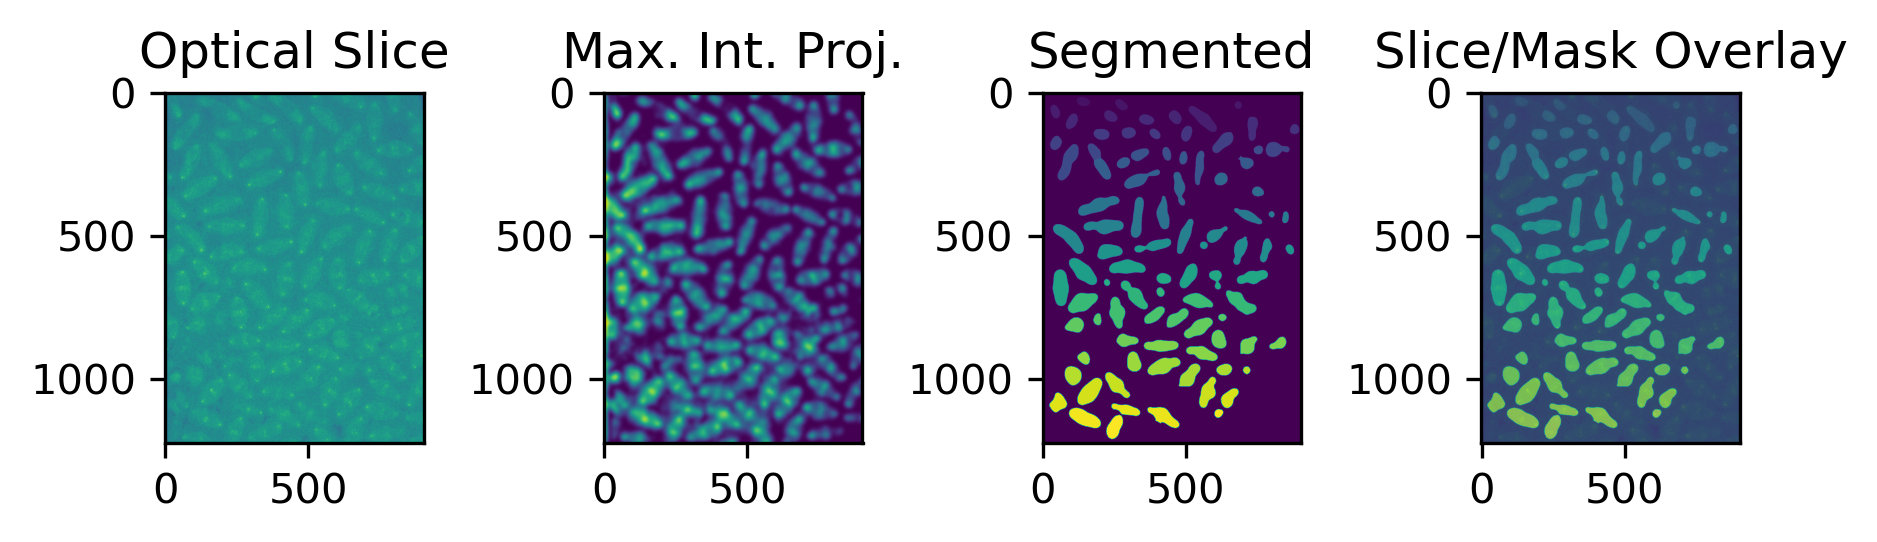

In [76]:
channel = 1
measured_regions_yfp, mask_yfp, image_slice = segment_channel(data_dir + fname, 
                             segment_dir + mip_fnames[channel -1 ],
                             z_slice=z_slice, nuc_diam=80, channel=channel,
                                       r_out=10, r_in=2)

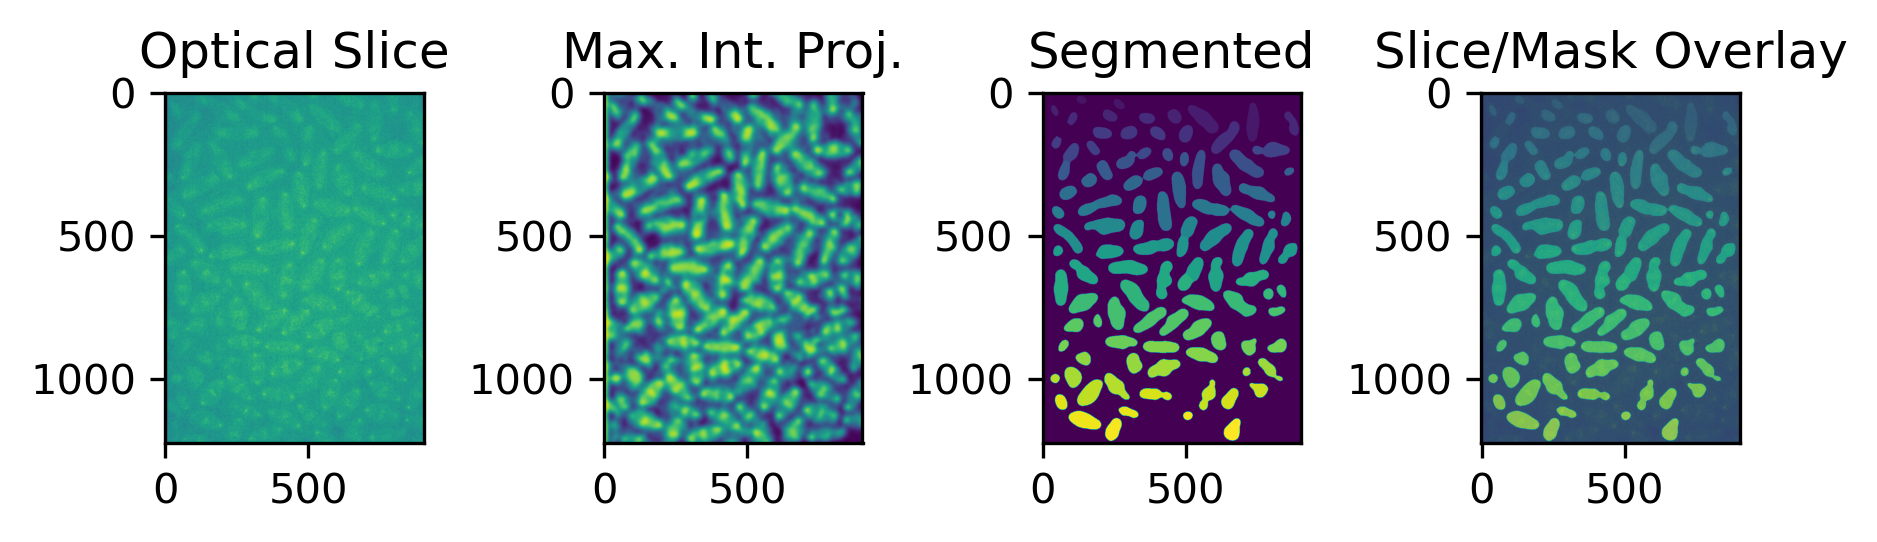

In [77]:
channel = 2
measured_regions_cfp, mask_cfp, image_slice = segment_channel(data_dir + fname, 
                             segment_dir + mip_fnames[channel-1],
                             z_slice=z_slice, nuc_diam=80, channel=channel,
                                       r_out=10, r_in=2)

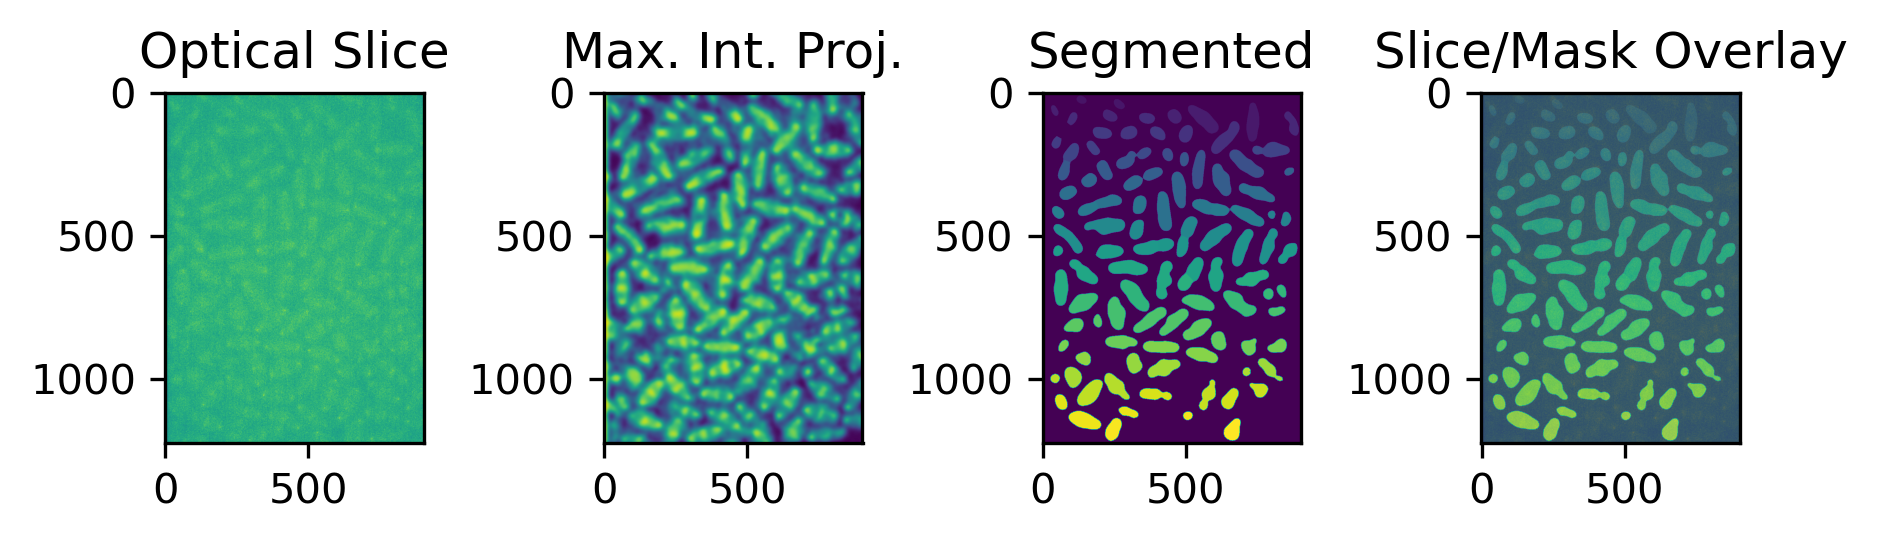

In [78]:
channel = 3
measured_regions_fret, mask_fret, image_slice = segment_channel(data_dir + fname, 
                             segment_dir + mip_fnames[channel - 2],
                             z_slice=z_slice, nuc_diam=80, channel=channel,
                                       r_out=10, r_in=2)

## Merge the measurements from the segmentation

In [79]:
measured_regions_master = match_labels(measured_regions_yfp, measured_regions_cfp, 'mean_intensity_CFP')
measured_regions_master = match_labels(measured_regions_master, measured_regions_fret, 'mean_intensity_FRET')

### Note
At this point, you should open the timeseries on FIJI and then mark the nuclei of interest using the point label function. Furthermore, you should label nuclei such that the delayed nuclei are labeled first. Subsequently, you should label corresponding, neighboring normal nuclei.

The function above returns some labels that you should avoid. This can be cross-checked by looking at the napari window.

## Classifying Nuclei

The immediate code block below will return the labels of the delayed nuclei, given you input a list of x, y coordinates for it. 

The first line reads in the csv file from FIJI, from where you will determine the coordinates of the delayed nuclei. The second line will then match those coordinates with the segmentation labels to match the ROIs.

The input should be marking the delayed nuclei first. Once all delayed nuclei have been marked in FIJI, you proceed to mark the neighboring normal nucleus, corresponding to each delayed nucleus. In this sense, the first half of coordinates are that of delayed nuclei and the second half of coordinates are the neighboring, corresponding, normal nuclei.

In [80]:
coord_fnames = '../data/20220117_series5/labels_t7.csv'

In [81]:
coords = load_coords(coord_fnames)
delayed_coords = coords[0:int(len(coords)/2)]
regular_coords = coords[int(len(coords)/2):len(coords)]
delayed_labels = match_coords(delayed_coords, measured_regions_master, max_distance=20)
regular_labels = match_coords(regular_coords, measured_regions_master, max_distance=20)

646.4316674833339
631.7672323775005
778.2286471226128
632.2115033739348
671.1951231093283
590.0390748019539
633.3726772462958
584.8144333978164
594.532793903744
748.807748533274
852.5152828226193
598.6353814089283
537.5855967015981
554.5492140577865
527.5347035067543
643.7827334606326
527.2363880870901
757.0146955963459
468.5313657900202
451.3164613775091
709.537607323798
504.62487819023767
471.0797613186087
524.2223807900571
518.9071442801832
648.4060556177094
431.56448776895155
407.774436754623
386.9795949815722
424.91660357309405
544.822784116297
620.7175807891437
317.354799204725
280.4136157667757
258.4966930855371
550.6767763570655
626.8059497809456
667.6018759342662
321.88938620462847
206.17914098287747
215.29148118399488
210.75637234574435
419.8370380580232
481.681108462134
568.7812583105649
229.58122025205222
366.7559049749836
118.43319745343545
651.5873349114713
172.2088549494767
95.83770784141068
95.05088708868595
288.76675551948523
160.89162398927843
510.2107770499199
382.79

In [82]:
delayed_labels

[58, 68, 68, 78, 78, 78, 78, 72, 69, 69, 69, 69, 69, 69, 89, 89]

In [84]:
regular_labels[5] = 79

In [85]:
regular_labels[10] = 62

In [86]:
regular_labels = regular_labels[:11]

In [87]:
regular_labels

[52, 63, 70, 65, 73, 79, 83, 77, 71, 74, 62]

In [63]:
visualize_rois(image_slice, measured_regions_master, mask_fret) # Pop up of napari viewer to select the labels

In [41]:
measured_regions_master.loc[(measured_regions_master['mean_intensity_CFP_corr_seg'].isna()) | (measured_regions_master['mean_intensity_FRET_corr_seg'].isna())] # Check for nuclei with no match

,label,centroid-0,centroid-1,area,bbox-0,bbox-1,bbox-2,bbox-3,intensity_image,mean_intensity_Sqh-mCh,mean_intensity_YFP,mean_intensity_CFP,mean_intensity_FRET,slice,mean_intensity_YFP_corr,mean_intensity_YFP_bg,mean_intensity_CFP_corr_seg,mean_intensity_CFP_bg,mean_intensity_FRET_corr_seg,mean_intensity_FRET_bg
74,75,1002.098536,669.833988,2801,980,633,1029,709,"[[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0...",251.712960,917.483756,309.367726,335.569439,"(slice(980, 1029, None), slice(633, 709, None))",68.002663,849.481092,NaN,NaN,NaN,NaN
84,85,1115.044828,24.481034,1160,1092,6,1140,42,"[[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0...",249.786207,799.188793,289.310345,303.458621,"(slice(1092, 1140, None), slice(6, 42, None))",134.545212,664.643581,NaN,NaN,NaN,NaN


In [88]:
embryo = '20220117_series5_t7_z04'

In [89]:
measurements = get_measurements_4(delayed_labels,
                                  
                                  regular_labels,
                                  measured_regions_master)

In [90]:
metadata = [embryo for i in range(len(measurements))]
measurements['metadata'] = metadata

In [45]:
test = measurements[measurements['tag'] != 'other']

<AxesSubplot:xlabel='tag', ylabel='FRET/YFP'>

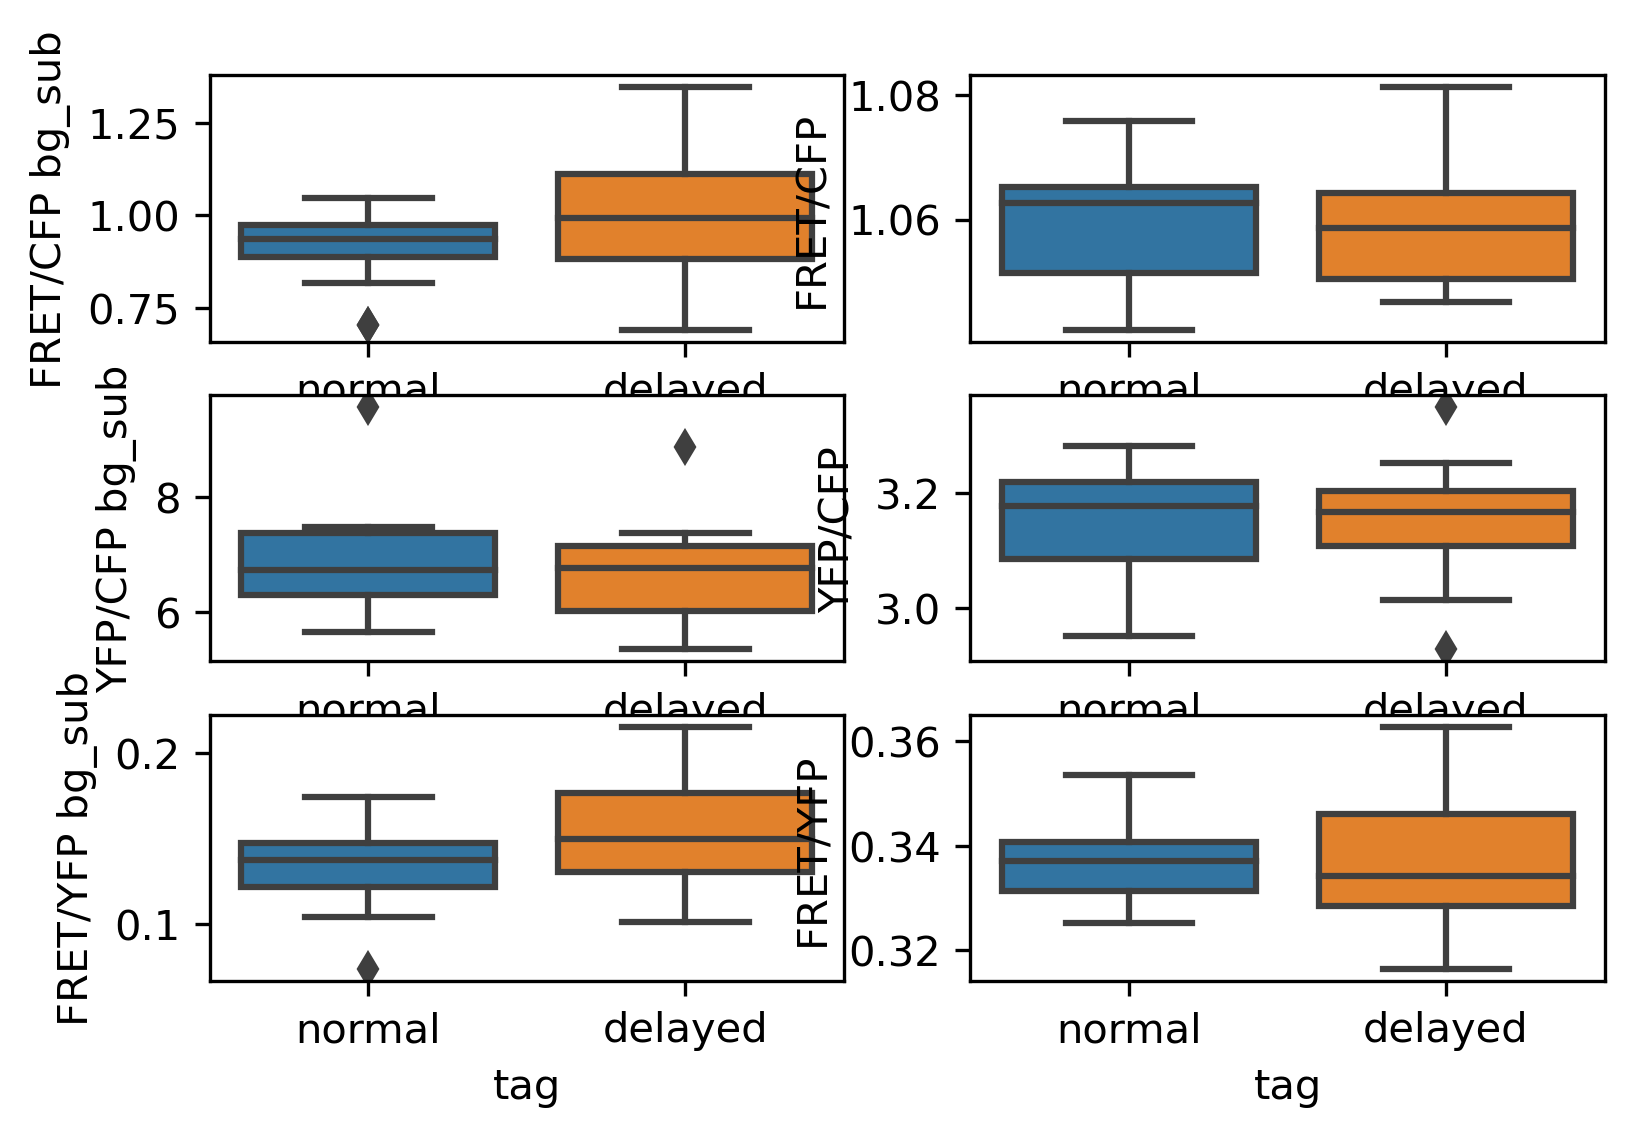

In [46]:
fig, ax = plt.subplots(3,2)
sns.boxplot(ax=ax[0,0], x='tag', y='FRET/CFP bg_sub', data=test)
sns.boxplot(ax=ax[0,1], x='tag', y='FRET/CFP', data=test)
sns.boxplot(ax=ax[1,0], x='tag', y='YFP/CFP bg_sub', data=test)
sns.boxplot(ax=ax[1,1], x='tag', y='YFP/CFP', data=test)
sns.boxplot(ax=ax[2,0], x='tag', y='FRET/YFP bg_sub', data=test)
sns.boxplot(ax=ax[2,1], x='tag', y='FRET/YFP', data=test)

In [91]:
output_dir = '../outputs/20220117_series5/'
fname = embryo + '_measurements.csv'
output = output_dir + fname

In [92]:
measurements.to_csv(output)

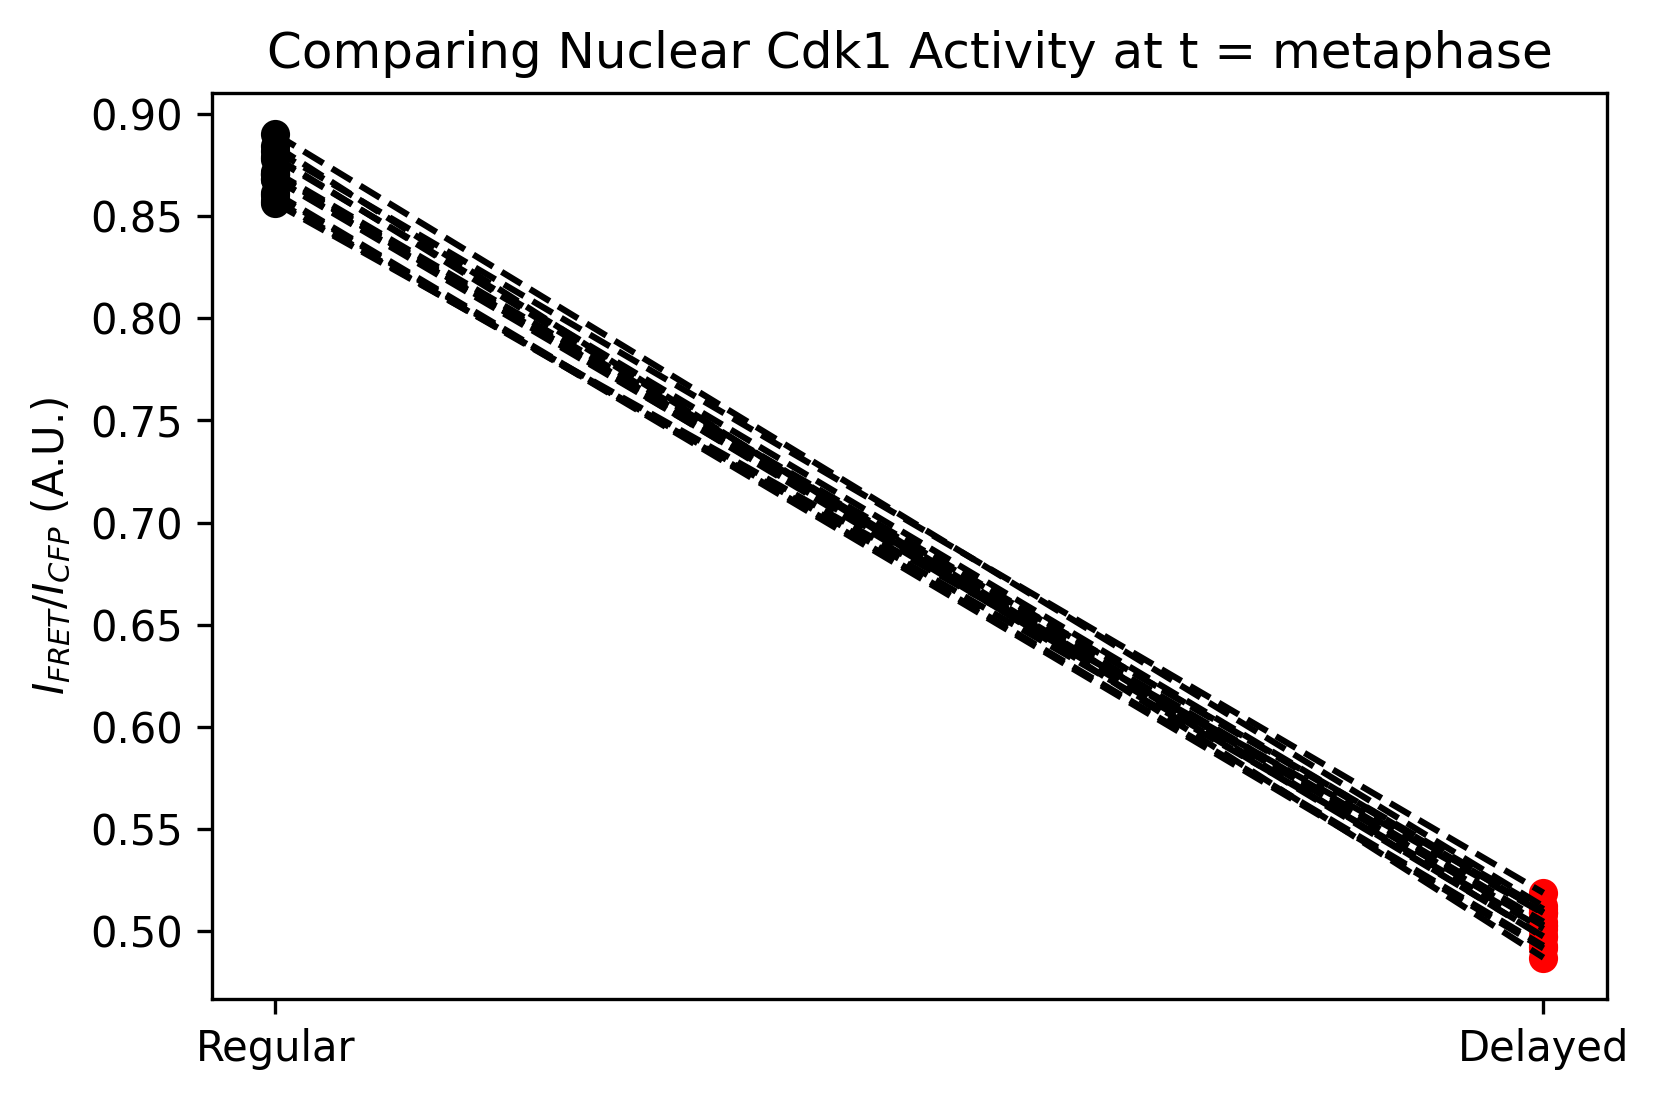

In [389]:
plot_paired_fret(fret_normal, fret_delayed, 'metaphase', save=False, 
                 output_dir='../figures/paired_fret_metaphase.png')

In [266]:
paired_ttest(fret_normal, fret_delayed)

p = 1.3303948734978546e-22
The two populations are statistically different


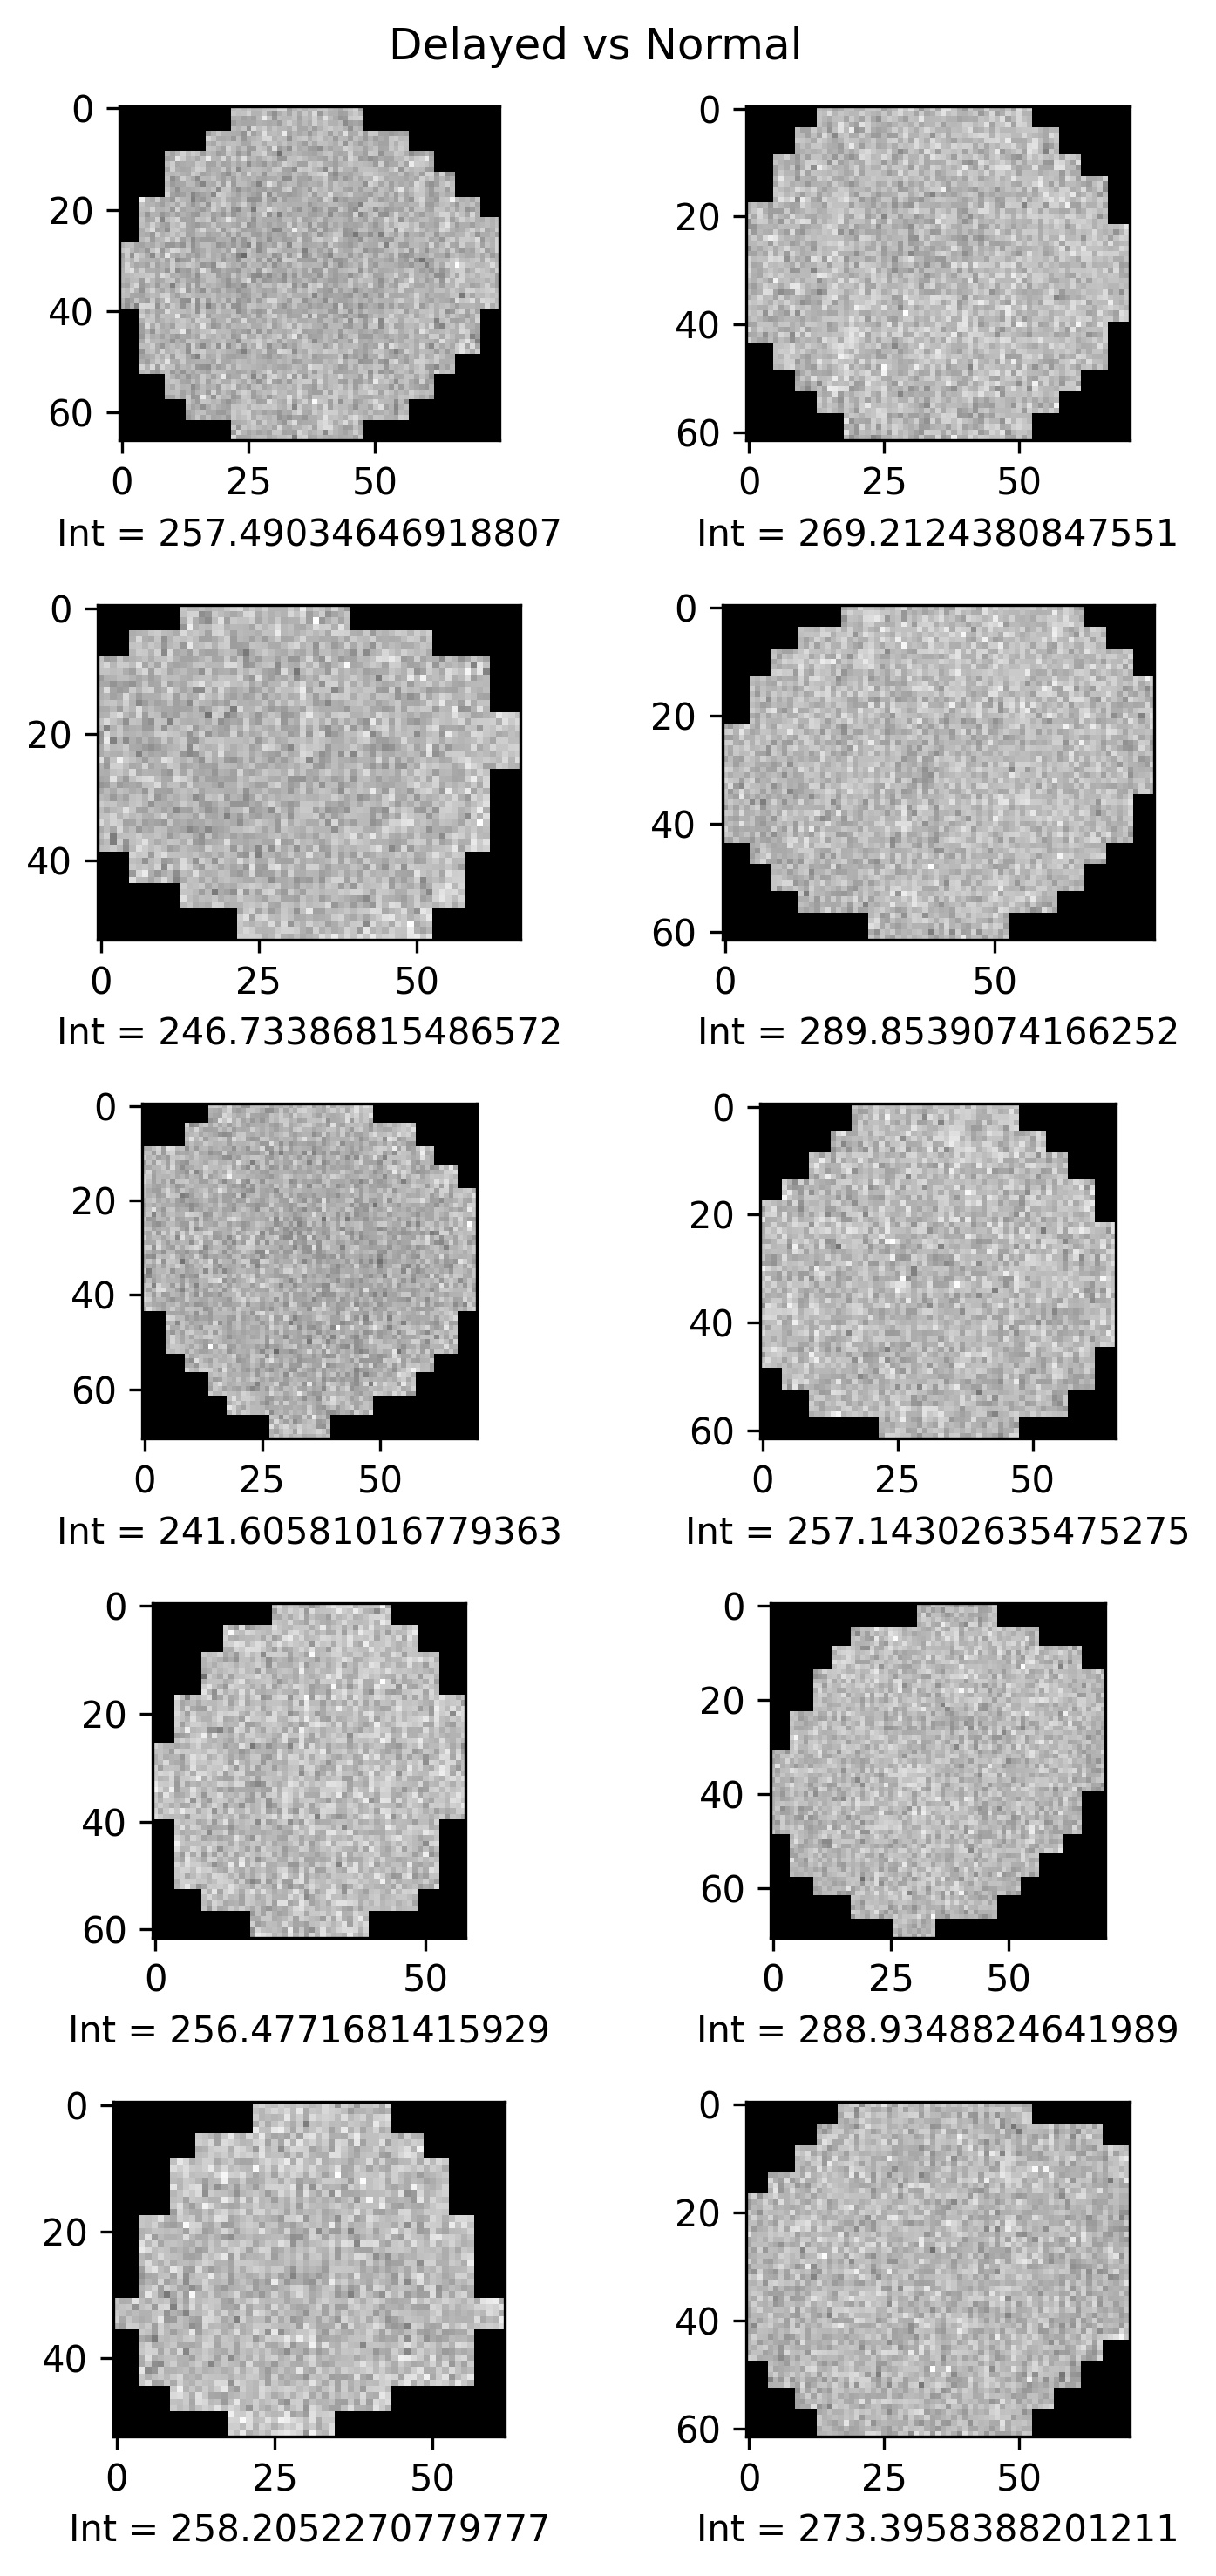

In [267]:
fig, ax = plt.subplots(len(delayed_labels_z10), 2, figsize=(5, 10))
for i in range(len(delayed_labels_z10)):
    ax[i, 0].imshow(measured_regions_z10['intensity_image'][delayed_labels_z10[i] - 1][:,:,0], cmap='gray')
    ax[i,0].set_xlabel('Int = ' + str(measured_regions_z10.loc[delayed_labels_z10[i] - 1].at['mean_intensity_Sqh-mCh']))
    ax[i, 1].imshow(measured_regions_z10['intensity_image'][normal_labels_z10[i] - 1][:,:,0], cmap='gray')
    ax[i,1].set_xlabel('Int = ' + str(measured_regions_z10.loc[normal_labels_z10[i] - 1].at['mean_intensity_Sqh-mCh']))              
fig.suptitle('Delayed vs Normal')
fig.tight_layout()
#plt.savefig('../figures/sqh_validation_z10.png')

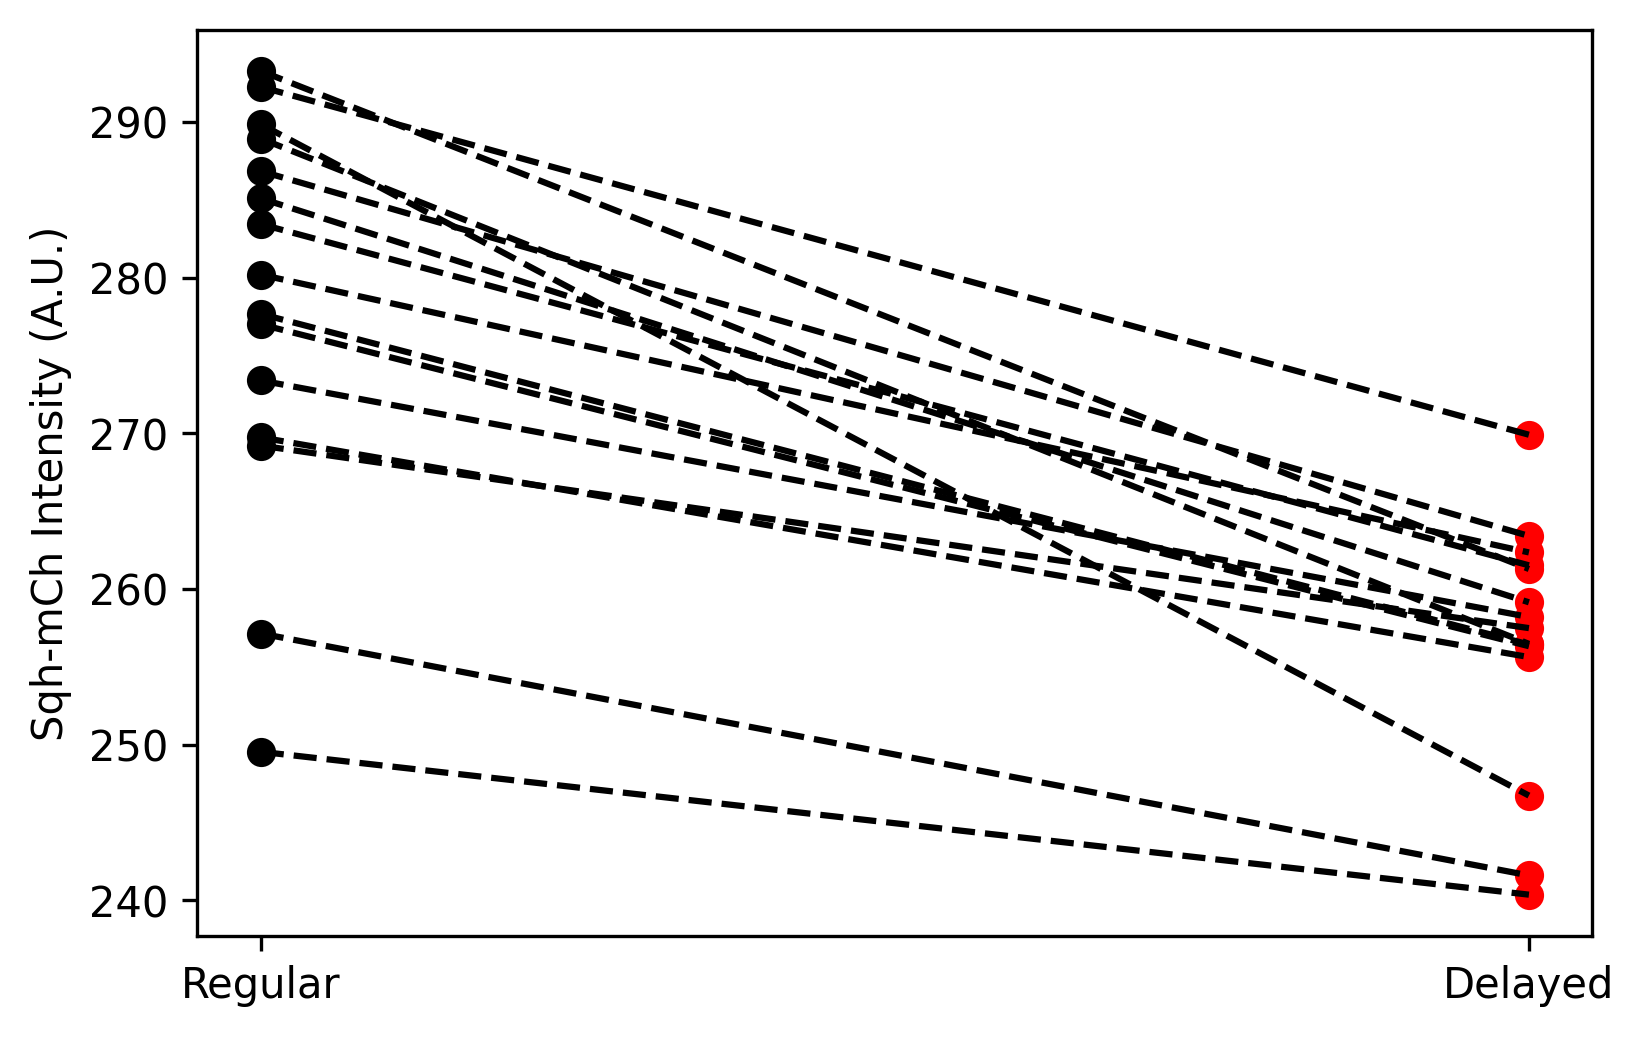

In [306]:
sqh_delayed_z10, sqh_normal_z10 = get_sqh_measurements(delayed_labels_z10,
                                                     normal_labels_z10, 
                                                     measured_regions_z10)

sqh_delayed_z16, sqh_normal_z16 = get_sqh_measurements(delayed_labels_z16,
                                                            normal_labels_z16,
                                                            measured_regions_z16)

sqh_normal = np.array(sqh_normal_z10 + sqh_normal_z16)
sqh_delayed = np.array(sqh_delayed_z10 + sqh_delayed_z16)

plot_paired_fret(sqh_normal, sqh_delayed, time='metaphase', ylabel='Sqh-mCh Intensity (A.U.)',
                title=False, save=False, output_dir='../figures/paired_sqh_intensity_metaphase.png')

In [269]:
paired_ttest(sqh_normal, sqh_delayed)

p = 1.8424765300476385e-07
The two populations are statistically different
